In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import pywt
#from pywt import wavedec
from sklearn import preprocessing, cross_validation, svm
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
from scipy.signal import *
from numpy.fft import * 
from matplotlib import *
from pylab import *
from sklearn.externals import joblib
from sklearn.grid_search import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import neighbors
from sklearn.metrics import roc_curve
#import django

C:\Users\Chris De Villier\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Chris De Villier\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
sys.version

'3.5.2 |Anaconda 4.1.1 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]'

In [3]:
import os
original_path =r"C:\Users\Chris De Villier\Documents\train_3"

def access_data():
    '''
    Access files in directories and get their names
    '''
    path = original_path
    zero_files =[]
    one_files = []
    file_list = [x for x in os.walk(path)]
    #print('Access files',file_list) #file_list)
    names = str(file_list).split(",")
    #print(names[3])
    df = pd.read_csv(r"C:\Users\Chris De Villier\Documents\train_and_test_data_labels_safe.csv")
    unsafe = df[df['safe']==0]
    unsafe_names = unsafe['image']
    for name in (names[2:]):
        if str(name).strip() not in str(unsafe_names).strip(): 
            nameparts = name.split("_")

            last_part_of_name = str(nameparts[2]).split(".")
            last_part_of_name = int(last_part_of_name[0])
            #print(last_part_of_name)
            if (last_part_of_name) == 0:
                zero_files.append(name.replace('"','').replace("'","").replace("[","").replace("]","").replace(")","").replace("(",""))
            elif (last_part_of_name) == 1:
                one_files.append(name.replace('"','').replace("'","").replace("[","").replace("]","").replace(")","").replace("(",""))
            else: print('failed ',name.replace('"','').replace("'","").replace("[","").replace("]","").replace(")","").replace("(",""))    
    return zero_files,one_files
            

In [4]:
def getFiles(files,path):
    ''' Get files contents. files are in .mat format (Matlab format)'''
    allfiles =[]
    allfiles_temp =[]
    corrupted_files =[]
    uncorrupted_files =[]
    empty = ' '

    for i in range(len(files)): #
        #print(i)
        #if i<100:
        path1 = path+"/"+str(files[i]).strip()
        print(i,empty,path1)
        try:
            contents = sio.loadmat(path1)
            data = contents['dataStruct']
            mdtype = data.dtype 
            ndata = {n: data[n][0, 0] for n in mdtype.names}
            columns = [n for n, v in ndata.items()]
            dataList = ndata['data']
            x = pd.DataFrame(dataList)
            #print('Step 1',)
            modifiedData = getSignalBands(x)
            temp = defineOneSecSamples(modifiedData)
            finalData = setMeanAndStd(temp)
            #modifiedData = defineOneSecSamples(modifiedData,5)
            #print(temp.shape)
            #print(finalData.head())
            allfiles.append(finalData)
            uncorrupted_files.append(files[i])
#             modifiedData = getSignalBands(x)

#             temp = defineOneSecSamples(modifiedData)
#             allfiles.append(temp)

            x = nan
            modifiedData = nan
            temp = None

        except ValueError :
            corrupted_files.append(path1)
            print("Error occurred trying to access content of .mat file")
            print(ValueError)
        except Exception as e :
            corrupted_files.append(path1)
            print("Error occurred trying to access content of .mat file")
            print(str(e))
           
    return allfiles,corrupted_files,uncorrupted_files


In [5]:
def defineOneSecSamples(file, step=400):
    smallerFile=[]
    start=0
    step_ = step
    x = pd.DataFrame(file)
    #print('Starting loop ',len(file)/step)
    for i in range(int((len(file))/step_)):
        #print('Starting loop ',i)
        temp = x.iloc[start:step,:].mean(axis=0)
        #print( 'Start ',start)
        #print( 'End ',step)
        start = step
        step +=step_ 
        smallerFile.append(temp)
    smaller_file = pd.DataFrame(smallerFile)
        #print('Starting inside loop {} of lenght {}'.format(j,len(file[0][i])))
    #print('Ending loop ')    
    return smaller_file

In [6]:
def aggregateData():
    
    zeros,ones = access_data()
    preict,corrupted_files_0,uncorrupted_files_0= getFiles(zeros,original_path)
    inter,corrupted_files_1,uncorrupted_files_1 = getFiles(ones,original_path)
    preictal_df=[]
    interictal_df =[]
   
    for index in range(len(preict)):
        if index == 0:
            pr = pd.DataFrame(preict[index])
            preictal_df.append(pr)
        else:
            pr = pd.DataFrame(preict[index])
            preictal_df.append(pr)
   
    for index in range(len(inter)):
        if index == 0:
            intertemp = pd.DataFrame(inter[index])
            interictal_df.append(intertemp)
        else:
            interTemp = pd.DataFrame(inter[index])
            interictal_df.append(intertemp)

    
    preictal= pd.concat(preictal_df,ignore_index=True)
    interictal= pd.concat(interictal_df,ignore_index=True)
    #preictal = ordered_channel_data(preictal)
    #interictal = ordered_channel_data(interictal)
   
    return preictal,interictal,corrupted_files_0,corrupted_files_1

In [11]:
 def getSignalBands(x):
    #print('Starting Get Signal function ',x.shape[1])
    for ch in range(1): #x.shape[1]
        
        delta = 'delta_'+str(ch)
        theta = 'theta_'+str(ch)
        alpha = 'alpha_'+str(ch)
        beta = 'beta_'+str(ch)
        limit = len(x)
        eeg = [] 
        #ch = 1 # particualr channel to study 
        #eeg = array(eeg)
        eeg = array(x)
        print(' signal 1')
        y = eeg[:,ch]         # the signal, study channel 'ch'
        L = len(y)            # signal length
        fs = 400.0              # sampling rate
        T = 1/fs                # sample time
        t= linspace(1,L,L)*T   # time vector
       
        f = fs*linspace(0,L

        
                        /10,L/10)/L  # single side frequency vector, real frequency up to fs/2
        Y = fft(y)
        
        #figure()
        filtered = []
       
        b= [] # store filter coefficient
        cutoff = [0.5,4.0,7.0,12.0,30.0]
        print(' signal 2')
        for band in range(0, len(cutoff)-1):
         print(' signal 3')
         wl = 2*cutoff[band]/fs*pi
         wh = 2*cutoff[band+1]/fs*pi
         M = 512      # Set number of weights as 128
         bn = zeros(M)
         print(' signal 3')
         for i in range(0,M):     # Generate bandpass weighting function
          n = i-  M/2       # Make symmetrical
          if n == 0:
           bn[i] = wh/pi - wl/pi;
          else:
           bn[i] = (sin(wh*n))/(pi*n) - (sin(wl*n))/(pi*n)   # Filter impulse response
         print(' signal 3')
         bn = bn*kaiser(M,5.2)  # apply Kaiser window, alpha= 5.2
         b.append(bn)
        
         [w,h]=freqz(bn,1)
         filtered.append(convolve(bn, y)) # filter the signal by convolving the signal with filter coefficients
       
        x[delta] = filtered[0][:limit]
        x[theta] = filtered[1][:limit]
        x[alpha] = filtered[2][:limit]
        x[beta] = filtered[3][:limit]
        
    #x = setMeanAndStd(x)
    #print(x)
    return x

In [7]:
def setMeanAndStd(x):
    
    for index in range(1):
        #print('Starting setMeanandSTd')
        delta = 'delta_'+str(index)
        theta = 'theta_'+str(index)
        alpha = 'alpha_'+str(index)
        beta = 'beta_'+str(index)
        nameMean = 'Mean_'+str(index)
        nameStd = 'Std_'+str(index)
        x[nameMean] = x[[index,delta,theta,alpha,beta]].mean(axis=1)
        x[nameStd] = x[[index,delta,theta,alpha,beta]].std(axis=1)
        fourier_real = 'fourier_real_'+str(index)
        fourier_imag = 'fourier_imag_'+str(index)
        namefourier = 'fourier_'+str(index)
        energy='energy_'+str(index)
        freq_sum='freq_sum_'+str(index)
        freq_std='freq_std_'+str(index)
        freq_mean='freq_mean_'+str(index)
        #freq_mean='freq_mean_'+str(index)
        signal = x[index]
        x[namefourier]=np.abs(np.fft.fft(signal))
        real =[]
        imag = []
        signal_energies = []
        frq_sum=[]
        signal_standard_deviation =[]
        signal_mean =[]
        position = 1
        #print('len of namefourier ',(x[namefourier].head()))
        #for k in range(len(x[namefourier])):
            #print(x[namefourier].head())
            #print(str(x[namefourier][:position][k])) #[:position]
            #print(str(x[namefourier][:1][1]))
            #print('position ',position)
            #print(len(xx[complex_fourier]),k,complex_fourier)[k]
#         orig_figure = np.complex(str(x[namefourier][:position]).replace('(',' ').replace(')',' ').replace(' ',''))

#         print(orig_figure)
#         r = orig_figure.real
#         im = orig_figure.imag
#         r_squared = abs(r*r)
#         im_squared = abs(im*im)
#         frequency_sum = r+im
#         signal_magnitude = sqrt(r_squared+im_squared)
#         signal_std = np.std([r,im])
#         sign_mean = np.mean([r,im])
#         real.append(r)
#         imag.append(im)
#         signal_energies.append(signal_magnitude)
#         frq_sum.append(frequency_sum)
#         signal_standard_deviation.append(signal_std)
#         signal_mean.append(sign_mean)
#         position +=1
        
#         x[fourier_real]= pd.DataFrame(real)
#         x[fourier_imag]= pd.DataFrame(imag)
#         x[energy]= pd.DataFrame(signal_energies)
#         x[freq_sum]= pd.DataFrame(frq_sum)
#         x[freq_std]= pd.DataFrame(signal_standard_deviation)
#         x[freq_mean]= pd.DataFrame(signal_mean)
#         x = x.drop(namefourier,1)
        #print(x.columns)
#         x[[0,'fourier_real_0','fourier_imag_0','energy_0','freq_sum_0','freq_std_0','freq_mean_0',
#              'theta_0','beta_0','alpha_0','delta_0']]
    #print(x)
    return x

In [12]:
preictal,interictal,err0,err1 = aggregateData()

0   C:\Users\Chris De Villier\Documents\train_3/3_1000_0.mat
 signal 1
 signal 2
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
1   C:\Users\Chris De Villier\Documents\train_3/3_1001_0.mat
 signal 1
 signal 2
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
2   C:\Users\Chris De Villier\Documents\train_3/3_1002_0.mat
 signal 1
 signal 2
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
3   C:\Users\Chris De Villier\Documents\train_3/3_1003_0.mat
 signal 1
 signal 2
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
4   C:\Users\Chris De Villier\Documents\train_3/3_1004_0.mat
 signal 1
 signal 2
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 signal 3
 sign

KeyboardInterrupt: 

In [9]:
def oversamplingTargetClass(prei, inter):
    
    targetAmount = prei.shape[0] - inter.shape[0]
    print('Target amount ',targetAmount)
    ratioOfSampling = targetAmount//inter.shape[0]
    interictalExtra = []
    interictalExtra.append(inter)
    print('ratioOfSampling ',ratioOfSampling)
    if ratioOfSampling >=1:
         for i in range(ratioOfSampling):
                interictalExtra.append(inter)
    interictal = pd.concat(interictalExtra,ignore_index=True)
        
    return interictal

In [10]:
def getFullData(prei,inter):
    
    #interictal = oversamplingTargetClass(prei, inter)
    prei['label'] = 0
    #interictal['label'] = 1
    inter['label'] = 1
    
    #fulldata = [prei, interictal]
    fulldata = [prei, inter]
    df_fulldata = pd.concat(fulldata,ignore_index=True)
    #print(prei.isnull().any().any() ,inter.isnull().any().any(), df_fulldata.isnull().any().any())
    return df_fulldata

In [ ]:
preictal.shape,interictal.shape

In [ ]:
preictal.to_csv('preictal_patient3.csv')

interictal.to_csv('interictal_patient3.csv')

In [10]:
preictal= pd.read_csv(r"C:\Users\Chris De Villier\Documents\preictal_patient3.csv")
interictal= pd.read_csv(r"C:\Users\Chris De Villier\Documents\interictal_patient3.csv")
#interictal_test= pd.read_csv(r"C:\Users\Chris De Villier\Documents\interictal_test.csv")

In [ ]:
#interictal = pd.concat([interictal_temp,interictal_test],axis=0,ignore_index=True)

In [ ]:
#interictal =interictal.reindex(np.random.permutation(interictal.index))

In [ ]:
#interictal= pd.read_csv(r"C:\Users\Chris De Villier\Documents\interictal_patient1.csv")

In [11]:
preictal.shape,interictal.shape

((1342200, 24), (89400, 24))

In [35]:
df_fulldata = getFullData(preictal[1200000:1300000],interictal[:80000])

C:\Users\Chris De Villier\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Chris De Villier\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
del df_fulldata['Unnamed: 0']

In [37]:
df_fulldata =df_fulldata.reindex(np.random.permutation(df_fulldata.index))

In [38]:
df_fulldata.shape

(180000, 24)

In [39]:
X = np.array(df_fulldata.drop(['label'], 1))
y = np.array(df_fulldata['label'])

In [40]:
X = preprocessing.scale(X)

In [41]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0)

In [42]:
#GBC = GradientBoostingClassifier(n_estimators=500,max_depth=5,random_state=1)
#GBC.fit(X_train,y_train)
clf = svm.SVC()
clf.fit(X_train,y_train)
#rf = RandomForestClassifier()
#rf.fit(X_train,y_train)
knnclf = neighbors.KNeighborsClassifier()
knnclf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
#joblib.dump(GBC,'patient3_model9_GBC.pkl')

In [43]:
joblib.dump(clf,'patient3_model9_smv.pkl')

['patient3_model9_smv.pkl']

In [44]:
#joblib.dump(rf,'patient3_model9_rf.pkl')

In [45]:
joblib.dump(knnclf,'patient3_model9_knnclf.pkl')

['patient3_model9_knnclf.pkl']

GBC Prediction

In [ ]:
prediction = GBC.predict(X_test)
confidence = GBC.score(X_test,y_test)
confidence

In [ ]:
predict = np.array(prediction)
results = stats.itemfreq(predict)
results

SVM prediction

In [ ]:
predictionsvm = clf.predict(X_test)
confidencesvm = clf.score(X_test,y_test)
confidencesvm

In [ ]:
predictsvm = np.array(predictionsvm)
resultssvm = stats.itemfreq(predictsvm)
resultssvm

Random Forest

In [ ]:
predictionrf = rf.predict(X_test)
confidencerf = rf.score(X_test,y_test)
confidencerf

In [ ]:
predictrf = np.array(predictionrf)
resultsrf = stats.itemfreq(predictrf)
resultsrf

Nearest Neigbour

In [ ]:
predictionknn = knnclf.predict(X_test)
confidenceknn = knnclf.score(X_test,y_test)
confidenceknn

In [ ]:
predictknn = np.array(predictionknn)
resultsknn = stats.itemfreq(predictknn)
resultsknn

# Validation Set

In [46]:
df_fullvalidationdata = getFullData(preictal[1300000:],interictal[80000:])
#df_fullvalidationdata = getFullData(preictal,interictal)
df_fullvalidationdata.shape

C:\Users\Chris De Villier\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Chris De Villier\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(51600, 25)

In [47]:
del df_fullvalidationdata['Unnamed: 0']

In [48]:
df_fullvalidationdata =df_fullvalidationdata.reindex(np.random.permutation(df_fullvalidationdata.index))

In [49]:
X_val_test = np.array(df_fullvalidationdata.drop(['label'], 1))
y_val_test = np.array(df_fullvalidationdata['label'])

In [50]:
X_val_test = preprocessing.scale(X_val_test)

Validating GBC

In [ ]:
predictionVal = GBC.predict(X_val_test)
confidenceVal = GBC.score(X_val_test,y_val_test)
confidenceVal

In [ ]:
predictVal = np.array(predictionVal)
resultsVal = stats.itemfreq(predictVal)
resultsVal

Validating SVM

In [ ]:
predictionValsvm = clf.predict(X_val_test)
confidenceValsvm = clf.score(X_val_test,y_val_test)
confidenceValsvm

In [ ]:
predictValsvm = np.array(predictionValsvm)
resultsValsvm = stats.itemfreq(predictValsvm)
resultsValsvm

Validating Random Forest

In [ ]:
predictionValRF = rf.predict(X_val_test)
confidenceValRF = rf.score(X_val_test,y_val_test)
confidenceValRF

In [ ]:
predictValRF = np.array(predictionValRF)
resultsValRF = stats.itemfreq(predictValRF)
resultsValRF

Validating K Nearest Neighbour

In [ ]:
predictionValknn = knnclf.predict(X_val_test)
confidenceValknn = knnclf.score(X_val_test,y_val_test)
confidenceValknn

In [ ]:
predictValknn = np.array(predictionValknn)
resultsValknn = stats.itemfreq(predictValknn)
resultsValknn

In [ ]:
resultsDF1 = pd.DataFrame(list(zip(predictionValRF,predictionVal,predictValknn,predictValsvm,
                                  y_val_test)),columns=('RF','GBC','KNN','SVM','Y'))




In [ ]:
resultsDF2 = pd.DataFrame(list(zip(predictionValRF,predictionVal,predictValknn,predictValsvm,
                                  y_val_test)),columns=('RF','GBC','KNN','SVM','Y'))


In [ ]:
resultsDF2[resultsDF2['Y'] == 0][658:]

In [ ]:
#resultsDF[resultsDF['KNN'] ==1]

In [ ]:
preictal_train= pd.read_csv(r"C:\Users\Chris De Villier\Documents\test_preictal_patient1.csv")
interictal_train= pd.read_csv(r"C:\Users\Chris De Villier\Documents\test_interictal_patient1.csv")

In [ ]:
df_testdata = getFullData(preictal_train,interictal_train)
#df_testdata = getFullData(preictal,interictal)
df_testdata.shape

In [ ]:
#del df_testdata['Unnamed: 0']
df_testdata.shape

In [ ]:
df_testdata =df_testdata.reindex(np.random.permutation(df_testdata.index))

In [ ]:
X = np.array(df_testdata.drop(['label'], 1))
y = np.array(df_testdata['label'])

In [ ]:
X = preprocessing.scale(X)

In [ ]:
uncorrupted_files

In [ ]:
test_path = r"C:\Users\Chris De Villier\Documents\test_2_new"

In [ ]:
testFileList = accessTestData(test_path)
files,corrupted_files,uncorrupted_files = getFiles(testFileList,test_path)

In [ ]:
df_testdata = pd.concat(files)

In [ ]:
#df_testdata = np.array(df_testdata)
X = preprocessing.scale(df_testdata)

In [ ]:
df_testdata.head()

In [51]:

# model1gbc = joblib.load('patient1_model1_GBC.pkl')
# model1knn = joblib.load('patient1_model1_knnclf.pkl')
# model1svm = joblib.load('patient1_model1_smv.pkl')
# model1rf = joblib.load('patient1_model1_rf.pkl')

# model2gbc = joblib.load('patient1_model2_GBC.pkl')
# model2knn = joblib.load('patient1_model2_knnclf.pkl')
# model2svm = joblib.load('patient1_model2_smv.pkl')
# model2rf = joblib.load('patient1_model2_rf.pkl')

# model3gbc = joblib.load('patient1_model3_GBC.pkl')
# model3knn = joblib.load('patient1_model3_knnclf.pkl')
# model3svm = joblib.load('patient1_model3_smv.pkl')
# model3rf = joblib.load('patient1_model3_rf.pkl')

# model4gbc = joblib.load('patient1_model4_GBC.pkl')
# model4knn = joblib.load('patient1_model4_knnclf.pkl')
# model4svm = joblib.load('patient1_model4_smv.pkl')
# model4rf = joblib.load('patient1_model4_rf.pkl')
                       
# model5gbc = joblib.load('patient1_model5_GBC.pkl')
# model5knn = joblib.load('patient1_model5_knnclf.pkl')
# model5svm = joblib.load('patient1_model5_smv.pkl')
# model5rf = joblib.load('patient1_model5_rf.pkl')
                       
# model6gbc = joblib.load('patient1_model6_GBC.pkl')
# model6knn = joblib.load('patient1_model6_knnclf.pkl')
# model6svm = joblib.load('patient1_model6_svm.pkl')

# model7gbc = joblib.load('patient1_model7_GBC.pkl')
# model7knn = joblib.load('patient1_model7_knnclf.pkl')
# model7svm = joblib.load('patient1_model7_svm.pkl')

model1 = joblib.load('patient3_model1_knnclf.pkl') 
model2 = joblib.load('patient3_model2_knnclf.pkl')
model3 = joblib.load('patient3_model3_knnclf.pkl')
model4 = joblib.load('patient3_model4_knnclf.pkl') 
model5 = joblib.load('patient3_model5_knnclf.pkl')
model6 = joblib.load('patient3_model6_knnclf.pkl')
model7 = joblib.load('patient3_model7_knnclf.pkl') 
model8 = joblib.load('patient3_model8_knnclf.pkl')
model9 = joblib.load('patient3_model9_knnclf.pkl')
model1svm = joblib.load('patient3_model1_smv.pkl') 
model2svm = joblib.load('patient3_model2_smv.pkl')
model3svm = joblib.load('patient3_model3_smv.pkl')
model4svm = joblib.load('patient3_model4_smv.pkl') 
model5svm = joblib.load('patient3_model5_smv.pkl')
model6svm = joblib.load('patient3_model6_smv.pkl')
model7svm = joblib.load('patient3_model7_smv.pkl') 
model8svm = joblib.load('patient3_model8_smv.pkl')
model9svm = joblib.load('patient3_model9_smv.pkl')


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [53]:
svm1=model1svm.predict(X_val_test)
print(model1svm.score(X_val_test,y_val_test))
predict = np.array(svm1)
print(stats.itemfreq(predict))
svm2=model2svm.predict(X_val_test)
model2svm.score(X_val_test,y_val_test)
svm3=model3svm.predict(X_val_test)
model3svm.score(X_val_test,y_val_test)
svm4=model4svm.predict(X_val_test)
model4svm.score(X_val_test,y_val_test)
svm5=model5svm.predict(X_val_test)
model5svm.score(X_val_test,y_val_test)
svm6=model6svm.predict(X_val_test)
model6svm.score(X_val_test,y_val_test)
svm7=model7svm.predict(X_val_test)
model7svm.score(X_val_test,y_val_test)
svm8=model8svm.predict(X_val_test)
model8svm.score(X_val_test,y_val_test)
svm9=model9svm.predict(X_val_test)
model9svm.score(X_val_test,y_val_test)

0.955891472868
[[    0 40556]
 [    1 11044]]


0.89631782945736438

In [58]:
knn1=model1.predict(X_val_test)
print(model1.score(X_val_test,y_val_test))
predict = np.array(knn1)
print(stats.itemfreq(predict))
knn2=model2.predict(X_val_test)
print(model2.score(X_val_test,y_val_test))
knn3=model3.predict(X_val_test)
print(model3.score(X_val_test,y_val_test))
knn4=model4.predict(X_val_test)
print(model4.score(X_val_test,y_val_test))
knn5=model5.predict(X_val_test)
print(model5.score(X_val_test,y_val_test))
knn6=model6.predict(X_val_test)
print(model6.score(X_val_test,y_val_test))
knn7=model7.predict(X_val_test)
print(model7.score(X_val_test,y_val_test))
knn8=model8.predict(X_val_test)
print(model8.score(X_val_test,y_val_test))
knn9=model9.predict(X_val_test)
print(model9.score(X_val_test,y_val_test))

0.97988372093
[[    0 41162]
 [    1 10438]]
0.958798449612
0.930096899225
0.926802325581
0.928275193798
0.921647286822
0.914399224806
0.927635658915
0.924612403101


In [77]:
resultsKnn = pd.DataFrame(list(zip(knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9,y_val_test)),
                         columns=('knn1','knn2','knn3','knn4','knn5','knn6','knn7','knn8','knn9','y')) #add y for training dataset
resultsKnn['predictionknn'] = round(resultsKnn[['knn1','knn2','knn3','knn4','knn5','knn6','knn7','knn8','knn9']].mean(axis=1))

In [78]:
resultsSvm = pd.DataFrame(list(zip(svm1,svm2,svm3,svm4,svm5,svm6,svm7,svm8,svm9,y_val_test)),
                         columns=('svm1','svm2','svm3','svm4','svm5','svm6','svm7','svm8','svm9','y')) #add y for training dataset
resultsSvm['prediction'] = round(resultsSvm[['svm1','svm2','svm3','svm4','svm5','svm6','svm7','svm8','svm9']].mean(axis=1))

In [73]:
resultsall = pd.DataFrame(list(zip(knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9,svm1,svm2,svm3,svm4,svm5,svm6,svm7,svm8,svm9,y_val_test)),
                         columns=('knn1','knn2','knn3','knn4','knn5','knn6','knn7','knn8','knn9','svm1','svm2','svm3','svm4','svm5','svm6','svm7','svm8','svm9','y')) #add y for training dataset
resultsall['prediction'] = round(resultsall[['knn1','knn2','knn3','knn4','knn5','knn6','knn7','knn8','knn9','svm1','svm2','svm3','svm4','svm5','svm6','svm7','svm8','svm9']].mean(axis=1))

In [85]:
resultsSvm.to_csv('resultsSvm_patient3.csv')

resultsKnn.to_csv('resultsKnn_patient3.csv')

In [2]:
resultsSvm= pd.read_csv(r"C:\Users\Chris De Villier\Documents\resultsSvm_patient3.csv")
resultsKnn= pd.read_csv(r"C:\Users\Chris De Villier\Documents\resultsKnn_patient3.csv")

In [16]:
resultsKnn = resultsKnn.drop(['Unnamed: 0'], 1)
resultsSvm = resultsSvm.drop(['Unnamed: 0'], 1)

In [19]:
resultsall = pd.concat([resultsKnn,resultsSvm],axis = 1)

In [29]:
resultsall = resultsall.drop(['predictionknn','prediction','y'], 1)

In [31]:
resultsall['prediction'] = round(resultsall[['knn1','knn2','knn3','knn4','knn5','knn6','knn7','knn8','knn9','svm1','svm2','svm3','svm4','svm5','svm6','svm7','svm8','svm9']].mean(axis=1))

C:\Users\Chris De Villier\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [34]:
resultsall['y'] = resultsKnn['y']

C:\Users\Chris De Villier\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
resultsKnn.head()

,knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9,y,predictionknn
0,0,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,1,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,0.0


In [18]:
resultsSvm.head()

,svm1,svm2,svm3,svm4,svm5,svm6,svm7,svm8,svm9,y,prediction
0,0,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,1,1,1,1,1,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,0.0


In [21]:
wrong_resultsKnn = resultsKnn[resultsKnn['y'] != resultsKnn['predictionknn']]

In [22]:
wrong_resultsKnn.head()

,knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9,y,predictionknn
32,0,1,1,1,1,1,1,0,0,0,1.0
51,1,0,1,1,1,1,1,0,0,0,1.0
56,0,0,0,0,1,1,1,1,1,0,1.0
63,0,1,1,1,1,1,1,1,1,0,1.0
82,1,1,1,1,1,1,0,1,0,0,1.0


In [23]:
results_percentageknn = 100-(len(wrong_resultsKnn)/(len(resultsKnn)/100))
results_percentageknn

93.77906976744185

In [25]:
wrong_resultssvm = resultsSvm[resultsSvm['y'] != resultsSvm['prediction']]
wrong_resultssvm.head()

,svm1,svm2,svm3,svm4,svm5,svm6,svm7,svm8,svm9,y,prediction
3,0,0,1,1,1,1,1,0,0,0,1.0
19,1,1,1,1,1,1,1,0,0,0,1.0
22,0,0,1,1,1,1,1,1,0,0,1.0
32,1,1,1,1,1,1,1,1,1,0,1.0
51,0,0,1,1,1,1,1,0,0,0,1.0


In [8]:
results_percentagesvm = 100-(len(wrong_resultssvm)/(len(resultsSvm)/100))
results_percentagesvm

91.68023255813954

In [35]:
resultsall.head()

,knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9,svm1,svm2,svm3,svm4,svm5,svm6,svm7,svm8,svm9,prediction,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
3,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0


In [38]:
wrong_resultsall = resultsall[resultsall['y'] != resultsall['prediction']]
wrong_resultsall.head()

,knn1,knn2,knn3,knn4,knn5,knn6,knn7,knn8,knn9,svm1,svm2,svm3,svm4,svm5,svm6,svm7,svm8,svm9,prediction,y
22,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0,1.0,0
32,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1.0,0
51,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,1.0,0
63,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1.0,0
82,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1.0,0


In [37]:
results_percentageall = 100-(len(wrong_resultsall)/(len(resultsall)/100))
results_percentageall

95.08720930232558

# Graphs, AUC, ROC Curve

In [43]:
roc_score_all = roc_auc_score(resultsall['y'], resultsall['prediction'])
roc_score_knn = roc_auc_score(resultsKnn['y'], resultsKnn['predictionknn'])
roc_score_svm = roc_auc_score(resultsSvm['y'], resultsSvm['prediction'])

In [44]:
roc_score_all,roc_score_knn,roc_score_svm

(0.96996445497630324, 0.96196682464454975, 0.94719194312796207)

In [46]:
from sklearn.metrics import roc_curve

fpr_knn, tpr_knn, _ = roc_curve(resultsKnn['y'], resultsKnn['predictionknn'])
fpr_svm, tpr_svm, _ = roc_curve(resultsSvm['y'], resultsSvm['prediction'])
fpr_combined, tpr_combined, _ = roc_curve(resultsall['y'], resultsall['prediction'])

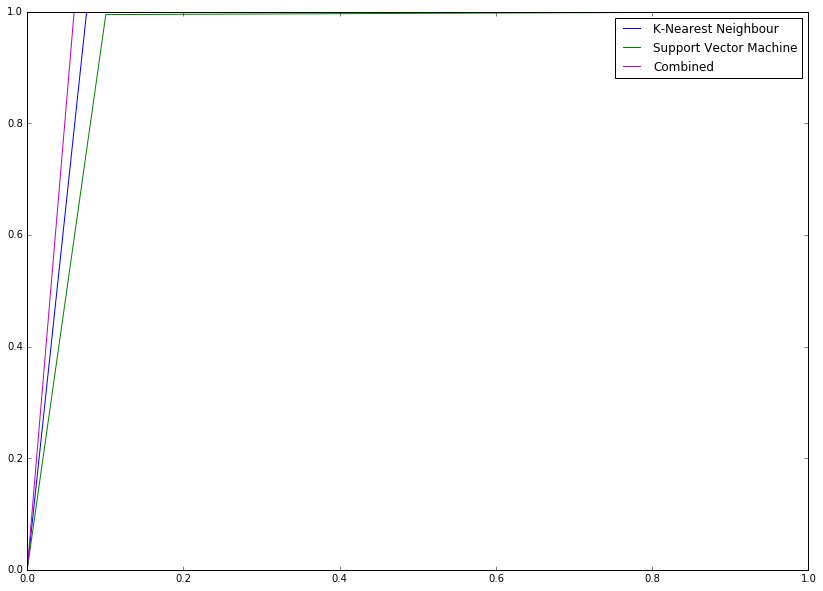

In [48]:
plt.figure(figsize=(14,10))
plt.plot(fpr_knn, tpr_knn, 'b', label='K-Nearest Neighbour')
plt.plot(fpr_svm, tpr_svm, 'g', label='Support Vector Machine')
#plt.plot(fpr_gbt, tpr_gbt, 'r', label='GBT')
plt.plot(fpr_combined, tpr_combined, 'm', label='Combined')
plt.legend(loc=0)
plt.show()

In [ ]:
# gbc = model1gbc.predict(X_val_test)
# svm= model1svm.predict(X_val_test)
# knn=model1knn.predict(X_val_test)
# rf=model1rf.predict(X_val_test)
# resultsDF1 = pd.DataFrame(list(zip(gbc,knn,svm,rf,y_val_test)),columns=('GBC','KNN','SVM','RF','y')) #add y for training dataset
# resultsDF1['avg1'] = resultsDF1[['GBC', 'KNN','SVM','RF']].mean(axis=1)

In [ ]:
# gbc = model2gbc.predict(X_val_test)
# svm= model2svm.predict(X_val_test)
# knn=model2knn.predict(X_val_test)
# rf=model2rf.predict(X_val_test)
# resultsDF2 = pd.DataFrame(list(zip(gbc,knn,svm,rf)),columns=('GBC','KNN','SVM','RF'))
# resultsDF2['avg2'] = resultsDF2[['GBC', 'KNN','SVM','RF']].mean(axis=1)

In [ ]:
# gbc = model3gbc.predict(X_val_test)
# svm= model3svm.predict(X_val_test)
# knn=model3knn.predict(X_val_test)
# rf=model3rf.predict(X_val_test)
# resultsDF3 = pd.DataFrame(list(zip(gbc,knn,svm,rf)),columns=('GBC','KNN','SVM','RF'))
# resultsDF3['avg3'] = resultsDF3[['GBC', 'KNN','SVM','RF']].mean(axis=1)

In [ ]:
# gbc = model4gbc.predict(X_val_test)
# #model4gbc.score(X,y)
# svm= model4svm.predict(X_val_test)
# #model4svm.score(X,y)
# knn=model4knn.predict(X_val_test)
# rf=model4rf.predict(X_val_test)
# #model4knn.score(X,y)
# resultsDF4 = pd.DataFrame(list(zip(gbc,knn,svm,rf)),columns=('GBC','KNN','SVM','RF'))
# resultsDF4['avg4'] = resultsDF4[['GBC', 'KNN','SVM','RF']].mean(axis=1)

In [ ]:
# gbc = model5gbc.predict(X_val_test)
# svm= model5svm.predict(X_val_test)
# knn=model5knn.predict(X_val_test)
# rf=model5rf.predict(X_val_test)
# resultsDF5 = pd.DataFrame(list(zip(gbc,knn,svm,rf)),columns=('GBC','KNN','SVM','RF'))
# resultsDF5['avg5'] = resultsDF5[['GBC', 'KNN','SVM','RF']].mean(axis=1)

In [ ]:
# gbc = model6gbc.predict(X)
# svm= model6svm.predict(X)
# knn=model6knn.predict(X)
# resultsDF6 = pd.DataFrame(list(zip(gbc,knn,svm)),columns=('GBC','KNN','SVM'))
# resultsDF6['avg6'] = resultsDF6[['GBC', 'KNN','SVM']].mean(axis=1)

In [ ]:
# gbc = model7gbc.predict(X)
# svm= model7svm.predict(X)
# knn=model7knn.predict(X)
# resultsDF7 = pd.DataFrame(list(zip(gbc,knn,svm)),columns=('GBC','KNN','SVM'))
# resultsDF7['avg7'] = resultsDF7[['GBC', 'KNN','SVM']].mean(axis=1)

In [ ]:
resultsDF = pd.concat([resultsDF1['avg1'],resultsDF2['avg2'],resultsDF3['avg3'],resultsDF4['avg4'],resultsDF5['avg5'],resultsDF1['y']],axis=1)

In [ ]:
resultsDF['prediction']= round(resultsDF[['avg1','avg2','avg3','avg4','avg5']].mean(axis=1))

In [ ]:
resultsDF['prediction'] = resultsDF['prediction'].astype('int')

In [ ]:
wrong_results = resultsDF[resultsDF['y'] != resultsDF['prediction']]

In [ ]:
results_percentage = 100-(len(wrong_results)/(len(resultsDF)/100))

In [ ]:
results_percentage

In [ ]:
resultsrf = pd.concat([resultsDF1['RF'],resultsDF2['RF'],resultsDF3['RF'],resultsDF4['RF'],resultsDF5['RF']],
                      axis=1)

In [ ]:
resultsrf.columns=['RF1','RF2','RF3','RF4','RF5']

In [ ]:
resultsrf['prediction']= round(resultsrf[['RF1','RF2','RF3','RF4','RF5']].mean(axis=1))

In [ ]:
resultsrf['y']=resultsDF1['y']

In [ ]:
resultsrf['prediction'] = resultsrf['prediction'].astype('int')

In [ ]:
wrong_results_rf = resultsrf[resultsrf['y'] != resultsrf['prediction']]

In [ ]:
results_percentage_rf = 100-(len(wrong_results_rf)/(len(resultsrf)/100))

In [ ]:
results_percentage_rf

In [ ]:
resultssvm = pd.concat([resultsDF1['SVM'],resultsDF2['SVM'],resultsDF3['SVM'],resultsDF4['SVM'],resultsDF5['SVM'],
                      resultsDF6['SVM'],resultsDF7['SVM']],axis=1)

In [ ]:
resultsknn = pd.concat([resultsDF1['KNN'],resultsDF2['KNN'],resultsDF3['KNN'],resultsDF4['KNN'],resultsDF5['KNN'],
                      resultsDF6['KNN'],resultsDF7['KNN']],axis=1)

In [ ]:
resultsgbc = pd.concat([resultsDF1['GBC'],resultsDF2['GBC'],resultsDF3['GBC'],resultsDF4['GBC'],resultsDF5['GBC'],
                      resultsDF6['GBC'],resultsDF7['GBC']],axis=1)

In [ ]:
resultsDF['Prediction'] = resultsDF.mean(axis=1) #round(resultsDF.mean(axis=1))

In [ ]:
#resultsDF[resultsDF['Prediction']>0.5]
#patient1_results = pd.DataFrame(list(zip(uncorrupted_files,resultssvm['Prediction'])),columns=('Files','Class'))
#patient1_results.to_csv('patient1_results.csv')

In [ ]:
#patient1_results

In [ ]:
#resultssvm['Prediction'] = round(resultssvm.mean(axis=1))

In [ ]:
#resultsknn['Prediction'] = round(resultsknn.mean(axis=1))

In [ ]:
#resultsgbc['Prediction'] = round(resultsgbc.mean(axis=1))

In [ ]:
#xx =pd.concat([resultsgbc['Prediction'],resultsknn['Prediction'],resultssvm['Prediction']], axis=0, join='outer')
         

In [ ]:
resultsrf

In [ ]:
#resultsknn[resultsknn['Prediction']==1]

In [ ]:
start=0
step=600
finish=600
for index in range(int(len(resultssvm)/step)):
    temp = resultssvm[start:finish]
    status = round(temp['Prediction'].mean(axis=0))
    print ('{} Status {}'.format(index,status))
    start+=step
    finish+=step
    


In [ ]:
#resultsDF[resultsDF['Prediction'] != resultsDF['y']]

In [ ]:
#resultssvm[resultssvm['Prediction']==1]

# Testing

In [ ]:
test_path = r"C:\Users\Chris De Villier\Documents\test_2_new"
#test_path = r"/data/train_1"
def accessTestData(path):
    '''
    Access files in directories and get their names
    '''

    testFileList =[]
    file_list = [x for x in os.walk(path)]
    #print(file_list)
    names = str(file_list).split(",")
    #print(names[3])
    for name in names[2:]:
        testFileList.append(name.replace('"','').replace("'","").replace("[","").replace("]","").replace(")","").replace("(",""))
  
    return testFileList

In [ ]:
def getResults(path):
    ''' Get files contents. files are in .mat format (Matlab format)'''
    model1gbc = joblib.load('patient1_model1_gbc.pkl')
    model1knn = joblib.load('patient1_model1_knnclf.pkl')
    model1svm = joblib.load('patient1_model1_svm.pkl')

    model2gbc = joblib.load('patient1_model2_GBC.pkl')
    model2knn = joblib.load('patient1_model2_knnclf.pkl')
    model2svm = joblib.load('patient1_model2_svm.pkl')

    model3gbc = joblib.load('patient1_model3_GBC.pkl')
    model3knn = joblib.load('patient1_model3_knnclf.pkl')
    model3svm = joblib.load('patient1_model3_svm.pkl')

    model4gbc = joblib.load('patient1_model4_GBC.pkl')
    model4knn = joblib.load('patient1_model4_knnclf.pkl')
    model4svm = joblib.load('patient1_model4_svm.pkl')

    model5gbc = joblib.load('patient1_model5_GBC.pkl')
    model5knn = joblib.load('patient1_model5_knnclf.pkl')
    model5svm = joblib.load('patient1_model5_svm.pkl')

    model6gbc = joblib.load('patient1_model6_GBC.pkl')
    model6knn = joblib.load('patient1_model6_knnclf.pkl')
    model6svm = joblib.load('patient1_model6_svm.pkl')

    model7gbc = joblib.load('patient1_model7_GBC.pkl')
    model7knn = joblib.load('patient1_model7_knnclf.pkl')
    model7svm = joblib.load('patient1_model7_svm.pkl')
    corrupted_files =[]
    results =[]
    fileNames =[]
    empty = ' '
    
    testFileList = accessTestData(test_path)
    files,corrupted_files,uncorrupted_files = getFiles(testFileList,test_path)
    print('Length of file ',len(testFileList))
    
    for i in range(len(files)):
        #ordered_file = ordered_channel_data(files[i])
        X = np.array(files[i])#files[i]
        X = preprocessing.scale(X)

        fileStatus,resultsDF = gradientBoostedPrediction(X)
        #fileStatus = svmPrediction(X)
        #fileStatus = randomForestPrediction(X) 

        fileNames.append(uncorrupted_files[i])
        results.append(fileStatus) #after prediction, append the class variable for the file to results
        print('Status is ...',fileStatus)
        #print('filename is ...',uncorrupted_files[i] )
    
#     ''' Gradient Boosted Training'''
#     gradientBoostedTraining(X_train,y_train)
#     ''' Random Forest Training'''
#     #randomForestTraining(X_train,y_train)
#     ''' SVM Training'''
    
#     svmTrain(X_train,y_train)
    
    return fileNames,results,resultsDF

In [ ]:
def gradientBoostedPrediction(X_test):  
    print('Starting on prediction')
    ''' load the pickled model first please'''
    #GBC = joblib.load('GBCPickle1.pkl')
    #predict = clf.predict(X_test)
    
    gbc = model1gbc.predict(X)
    svm= model1svm.predict(X)
    knn=model1knn.predict(X)
    resultsDF1 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF1['avg1'] = resultsDF1[['GBC', 'KNN','SVM']].mean(axis=1)

    gbc = model2gbc.predict(X)
    svm= model2svm.predict(X)
    knn=model2knn.predict(X)
    resultsDF2 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF2['avg2'] = resultsDF2[['GBC', 'KNN','SVM']].mean(axis=1)

    gbc = model3gbc.predict(X)
    svm= model3svm.predict(X)
    knn=model3knn.predict(X)
    resultsDF3 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF3['avg3'] = resultsDF3[['GBC', 'KNN','SVM']].mean(axis=1)

    gbc = model4gbc.predict(X)
    #model4gbc.score(X,y)
    svm= model4svm.predict(X)
    #model4svm.score(X,y)
    knn=model4knn.predict(X)
    #model4knn.score(X,y)
    resultsDF4 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF4['avg4'] = resultsDF4[['GBC', 'KNN','SVM']].mean(axis=1)

    gbc = model5gbc.predict(X)
    svm= model5svm.predict(X)
    knn=model5knn.predict(X)
    resultsDF5 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF5['avg5'] = resultsDF5[['GBC', 'KNN','SVM']].mean(axis=1)

    gbc = model6gbc.predict(X)
    svm= model6svm.predict(X)
    knn=model6knn.predict(X)
    resultsDF6 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF6['avg6'] = resultsDF6[['GBC', 'KNN','SVM']].mean(axis=1)

    gbc = model7gbc.predict(X)
    svm= model7svm.predict(X)
    knn=model7knn.predict(X)
    resultsDF7 = pd.DataFrame(list(zip(gbc,knn,svm,y)),columns=('GBC','KNN','SVM','Y'))
    resultsDF7['avg7'] = resultsDF7[['GBC', 'KNN','SVM']].mean(axis=1)

    resultsDF = pd.concat([resultsDF1['avg1'],resultsDF2['avg2'],resultsDF3['avg3'],resultsDF4['avg4'],resultsDF5['avg5'],
                          resultsDF6['avg6'],resultsDF7['avg7']],axis=1)

    resultsDF['Prediction'] = round(resultsDF.mean(axis=1))
    
    #predict = np.array(predict)
    predict = np.array(resultsDF['Prediction'])
    prediction = stats.itemfreq(predict)
    print(prediction)
    if len(prediction) == 1:
        status = prediction[0][0]
    elif len(prediction) == 2:
        if prediction[0][1] > prediction[1][1]:
            status = 0
            print(status)
        elif prediction[0][1] < prediction[1][1]:
            status = 1
            print(status)
        else : 
            status = 0.5
            print(status)
    
    return status,resultsDF

In [ ]:
names,results,resultsdf = getResults(test_path)